In [1]:
import torch
import os
import numpy as np
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

import datetime
date_string = str(datetime.date.today())
print(date_string)

dir_name = "./" + date_string + "_result/"
if not os.path.isdir(dir_name):
    os.mkdir(dir_name)
else:
    print(dir_name + "is exist")

print(dir_name)

True
NVIDIA GeForce GTX 1660
2023-06-24
./2023-06-24_result/


In [23]:
#adjusting environment setting
bin_w = 23
bin_h = 37
input_per_bin = 12
print("now test size = ",bin_w,bin_h)

now test size =  23 37


In [24]:
# shelf next fit 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
import time
from collections import deque
import random
from matplotlib import pylab as plt

try:
    os.remove("train_state_action.txt")
except OSError as e:
    print(e)
else:
    print("File is deleted successfully")

#get all slice info
#file = open("slice_data/full_bin_" + str(bin_w) + "_" + str(bin_h) + "_100.txt",'r')
file = open("shuffle_data/full_bin_" + str(bin_w) + "_" + str(bin_h) + "_100.txt",'r')
#file = open("slice_data/temp_23_37.txt","r")
content = file.read()
file.close
slices = content.split('\n')
#print(slices)
if slices[-1] == "":
    print("empty")
    slices.pop()
input_count = 0
shape = (bin_w,bin_h*2,)
tree_tensor = torch.zeros(shape)
state1_ = tree_tensor.reshape(1,bin_w*bin_h*2) 
time0 = time.time()
total_accept = 0 #total item accepted numbers in all episodes 
total_area = 0  #total area count of "1" episode
accept_prob_per_board_test = [] #store accept rate of each episode
PE_per_board_test = [] #store PE of each episode
test_state_img = []
test_img = []
action_count = [0] * (bin_w*bin_h+1) #calculate all action using numbers 

test_episode = 100

for i in range(test_episode): 

    shelf_height = 0 #show current shelf line
    #random.shuffle(slices)
    status = 1
    input_count = 0
    accepted_count = 0
    total_area = 0
    current_highest = 0
    tree_tensor = torch.zeros(shape)
    state1_ = tree_tensor.reshape(1,bin_w*bin_h*2) 
    while(status == 1): #1 board
        #set state        
        new_slice = slices[i*input_per_bin + input_count].split()
        width = new_slice[0]
        height = new_slice[1]
        width_ = float(width) / 100
        height_ = float(height) / 100
        width = int(width_)
        height = int(height_)
        input_count += 1
        #print("input no.",input_count,":",width,height)
        case = -1 
        #deploy input item into another side of bin in tensor
        for index in range(bin_w*bin_h,bin_w*bin_h*2): #clear second half of bin
            state1_[0,index] = 0
      
        for y in range(height):
            for x in range(width):
                state1_[0,(bin_w*bin_h*2)- bin_w + x - (bin_w*y)] = 1
        #show new item and state
        with open("train_state_action.txt", 'a') as f:
            f.write("episode:")
            f.write(str(i+1))
            f.write("step:")
            f.write(str(input_count))
            f.write("\n")
            f.write("now shelf:")
            f.write(str(shelf_height))
            f.write("\n")
        with open("train_state_action.txt", 'a') as f:
            f.write("new:\n")
        for y in range(bin_h*2 -1 ,-1,-1):
            if y == bin_h -1 :
                with open("train_state_action.txt", 'a') as f:
                    f.write("bin:\n")
            for x in range(bin_w):
                with open("train_state_action.txt", 'a') as f:
                    if state1_[0,x+bin_w*y] < 1:
                        f.write("0")
                    else:
                        f.write("1")
            with open("train_state_action.txt", 'a') as f:
                f.write("\n")    


        # choose action_
        if bin_h - shelf_height >=  height:
            if state1_[0,bin_w * shelf_height + bin_w -1] == 0:#this shelf still have space
                for index in range(bin_w):
                    if state1_[0,bin_w * shelf_height + index] == 0: #this shelf still have space
                        if  bin_w - index >= width : #this shelf space is enough
                            action_ = bin_w * shelf_height + index 
                            case = 1
                            if height + shelf_height > current_highest:
                                current_highest = height + shelf_height
                            break
                        else:
                            if bin_h - current_highest >=  height:
                                #print("no space to fit, open next shelf")
                                shelf_height = current_highest
                                action_ = bin_w * shelf_height
                                case = 2
                                if height + shelf_height > current_highest:
                                    current_highest = height + shelf_height
                                break
                            else:
                                #print("open next shelf still no space,do no action")
                                action_ = -1
                                case = 3
                                break
            else: #this shelf is full
                #print("this shelf full,open new shelf")
                shelf_height = current_highest   
                if bin_h - shelf_height >=  height:
                    action_ = bin_w * shelf_height
                    case = 4
                    if height + shelf_height > current_highest:
                        current_highest = height + shelf_height
                else:
                    action_ = -1
        
        else:
            #print("no more space for this")
            case = 5
            action_ = -1


        #print("action_ = ", action_ )
        with open("train_state_action.txt", 'a') as f:
            f.write("action:")
            f.write(str(action_))
            f.write("\n")
            f.write("case:")
            f.write(str(case))
            f.write("\n")
        #deploy
        if action_ != -1:
            accepted_count += 1
            total_accept += 1
            total_area += width * height
            for y in range(height):
                for x in range(width):
                    state1_[0,action_+x+bin_w*y] = 1

    

        if input_count == input_per_bin:
            accept_prob_per_board_test.append(accepted_count/input_per_bin)
            PE_per_board_test.append(total_area / (bin_w * bin_h))
            finish_img = state1_.reshape(bin_h*2,-1)
            test_img.append(finish_img)
        
            status = 0 #one board done, exit while and clear board

    print("episode:",i)
    
total_accept_rate_string = "total accept rate: " + str(total_accept/(100*input_per_bin))
total_PE_string = "total PE: " + str(sum(PE_per_board_test)/len(PE_per_board_test))

print(total_accept_rate_string)
print(total_PE_string)
print(str(bin_w) + "*" + str(bin_h) + " " + str(test_episode) + " episodes test finished.")


File is deleted successfully
empty
episode: 0
episode: 1
episode: 2
episode: 3
episode: 4
episode: 5
episode: 6
episode: 7
episode: 8
episode: 9
episode: 10
episode: 11
episode: 12
episode: 13
episode: 14
episode: 15
episode: 16
episode: 17
episode: 18
episode: 19
episode: 20
episode: 21
episode: 22
episode: 23
episode: 24
episode: 25
episode: 26
episode: 27
episode: 28
episode: 29
episode: 30
episode: 31
episode: 32
episode: 33
episode: 34
episode: 35
episode: 36
episode: 37
episode: 38
episode: 39
episode: 40
episode: 41
episode: 42
episode: 43
episode: 44
episode: 45
episode: 46
episode: 47
episode: 48
episode: 49
episode: 50
episode: 51
episode: 52
episode: 53
episode: 54
episode: 55
episode: 56
episode: 57
episode: 58
episode: 59
episode: 60
episode: 61
episode: 62
episode: 63
episode: 64
episode: 65
episode: 66
episode: 67
episode: 68
episode: 69
episode: 70
episode: 71
episode: 72
episode: 73
episode: 74
episode: 75
episode: 76
episode: 77
episode: 78
episode: 79
episode: 80
epi

total accept rate:  0.7391666666666666
average PE:  0.6612925969447712


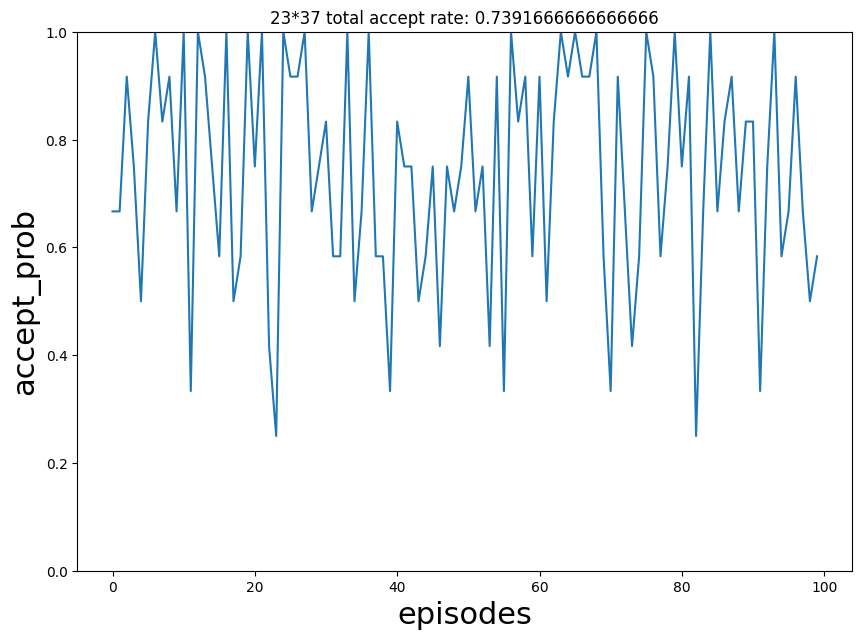

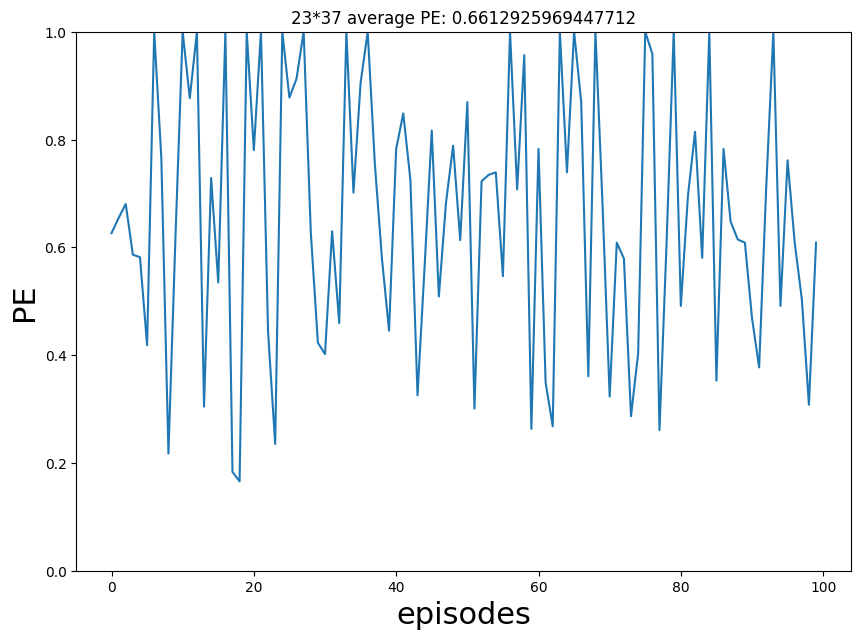

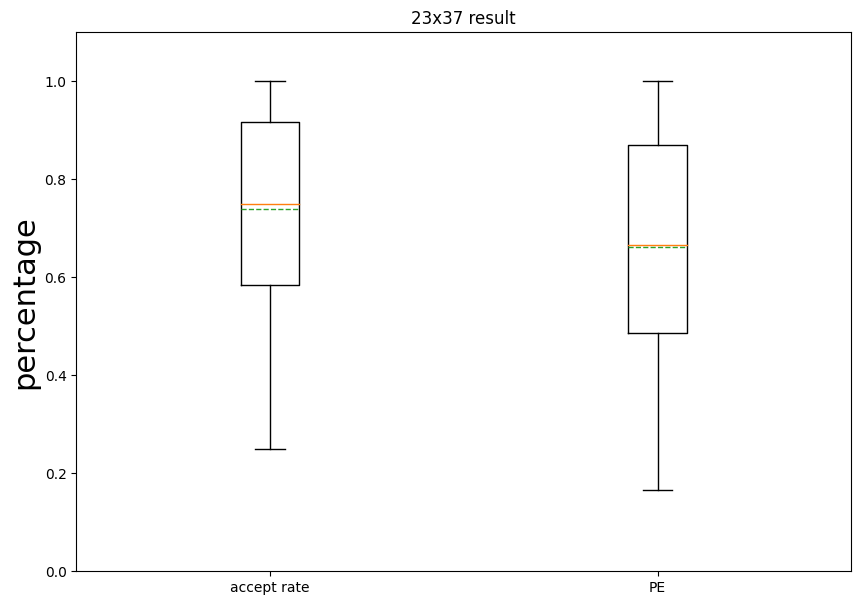

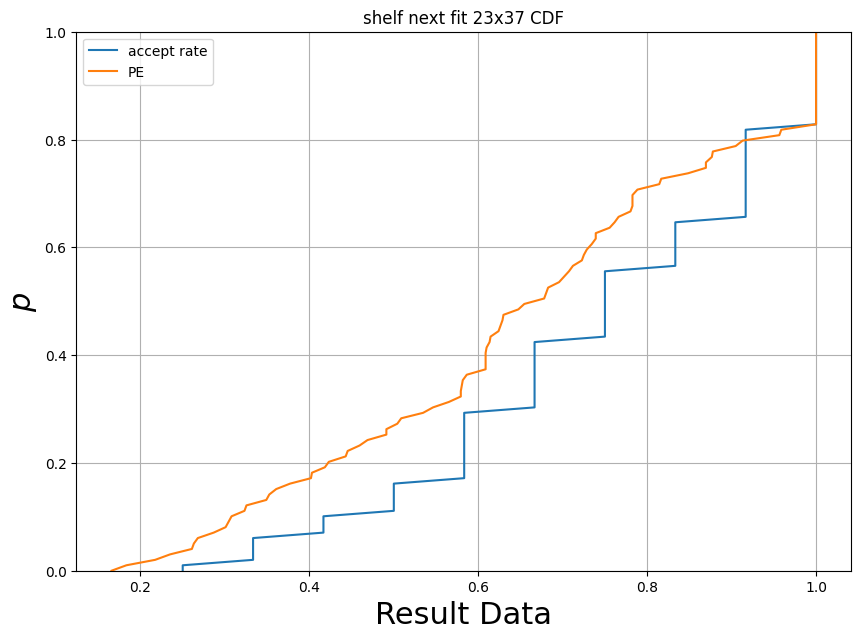

In [25]:
import copy
total_accept_test = total_accept
test_epochs = test_episode
string_accept_prob_per_board_test = str(bin_w) + "*" + str(bin_h) + " total accept rate: " + str(total_accept_test/(test_epochs*input_per_bin))
string_PE_per_board_test = str(bin_w) + "*" + str(bin_h) + " average PE: " +str(sum(PE_per_board_test) / len(PE_per_board_test))

#accept rate plot
plt.figure(figsize=(10,7))
plt.ylim(0,1)
plt.plot(accept_prob_per_board_test)
plt.title(string_accept_prob_per_board_test)
plt.xlabel("episodes",fontsize=22)
plt.ylabel("accept_prob",fontsize=22) 
plt.savefig(dir_name + date_string + "_" + str(bin_w) + "x" + str(bin_h) + "_test_accept_prob_per_board.png",dpi=300)

#PE plot
plt.figure(figsize=(10,7))
plt.ylim(0,1)
plt.title(string_PE_per_board_test)
plt.plot(PE_per_board_test)
plt.xlabel("episodes",fontsize=22)
plt.ylabel("PE",fontsize=22)
plt.savefig(dir_name + date_string + "_" + str(bin_w) + "x" + str(bin_h) + "_test_PE_per_board.png",dpi=300)

#box plot
plt.figure(figsize=(10,7))
plt.ylim(0,1.1)
x_labels = "accept rate","PE"
plt.boxplot([accept_prob_per_board_test,PE_per_board_test], labels = x_labels, showfliers=True,showmeans = True, meanline = True)
plt.title(str(bin_w) + "x" + str(bin_h) + " result")
plt.ylabel("percentage",fontsize=22) 
plt.savefig(dir_name + date_string + "_" + str(bin_w) + "x" + str(bin_h) + "_test_box.png",dpi=300)

#CDF plot
sorted_accept_prob_per_board_test = copy.deepcopy(accept_prob_per_board_test)
sorted_accept_prob_per_board_test.sort() #sort small to big
p1 = 1. * np.arange(len(sorted_accept_prob_per_board_test)) / (len(sorted_accept_prob_per_board_test) - 1) # calculate the proportional values of samples
sorted_PE_per_board_test = copy.deepcopy(PE_per_board_test)
sorted_PE_per_board_test.sort()
p2 = 1. * np.arange(len(sorted_PE_per_board_test)) / (len(sorted_PE_per_board_test) - 1)

plt.figure(figsize=(10,7))
plt.ylim(0,1)
plt.title("shelf next fit " + str(bin_w) + "x" + str(bin_h) + " CDF")
plt.plot(sorted_accept_prob_per_board_test, p1)
plt.plot(sorted_PE_per_board_test, p2)
plt.legend(['accept rate','PE']) #mark line's name
plt.xlabel("Result Data", fontsize=22)
plt.ylabel("$p$", fontsize=22)
plt.grid(True)
plt.savefig(dir_name + date_string + "_" + str(bin_w) + "x" + str(bin_h) + "_test_CDF.png",dpi=300)


print("total accept rate: ",total_accept_test/(100*input_per_bin))
print("average PE: ",sum(PE_per_board_test) / len(PE_per_board_test))

import csv
#save data to csv
test_data = zip(["test accept rate"] + accept_prob_per_board_test , ["test PE"] + PE_per_board_test)
test_data = list(test_data)
np.savetxt(dir_name + date_string + "_test_" + str(bin_w) + "x" + str(bin_h) + ".csv",test_data, delimiter =", ", fmt ='% s')